In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

from typing import *
import PIL
import mimetypes
from functools import partial
from pathlib import Path
from parameter import *

In [3]:
from fastai import datasets # quick util to get and untar data
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/Users/jacklu/.fastai/data/imagenette2-160')

In [4]:
#export
Path.ls = lambda x: list(x.iterdir())

In [5]:
path.ls()
path_val = path/'val'
path_tench = path/'val'/'n01440764'

print(path.ls())
print()
print(path_val.ls())
print()
print(path_tench.ls()[:3])

[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val')]

[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03394916'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03417042'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03445777'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n02102040'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03425413'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03888257'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03028079'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03000684'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n02979186')]

[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764/n01440764_32420.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764/n

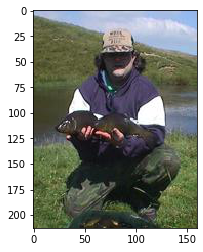

In [6]:
path_tench = path/'val'/'n01440764'
img_fn = path_tench.ls()[0]
img = PIL.Image.open(img_fn)
plt.imshow(img)

In [7]:
#export
image_exts = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
' '.join(image_exts)

'.jpe .ppm .ras .xpm .xbm .rgb .jpeg .jpg .svg .ico .pgm .tif .pnm .pbm .xwd .tiff .ief .gif .bmp .png'

## Get Files

In [8]:
#export
from collections import OrderedDict

def listify(inp):
    if inp is None: return []
    if isinstance(inp, list): return inp
    if isinstance(inp, str): return [inp]
    if isinstance(inp, Iterable): return list(inp)
    return [inp]

def setify(inp):
    return inp if isinstance(inp, set) else set(listify(inp))

def uniqueify(items, sort=False):
    res = list(OrderedDict.fromkeys(items).keys())
    return res.sort() if sort else res

In [9]:
#export
def get_files(path, exts=None, recurse=False, include=None):
    def get_file_paths(path, files, exts=None):
        # filenames -> PosixPaths filtered by extensions
        path = Path(path)
        in_exts = lambda o: (not exts) or (f".{o.split('.')[-1].lower()}" in exts)
        return [path/f for f in files if not is_hidden(f) and in_exts(f)]
    
    path, exts = Path(path), {e.lower() for e in setify(exts)}
    is_hidden = lambda o: o.startswith('.')
    
    if recurse:
        files = []
        for i, (p, d, f) in enumerate(os.walk(path)):
            if include and i == 0:
                d[:] = [o for o in d if o in include]
            else:
                d[:] = [o for o in d if not is_hidden(o)]
            files += get_file_paths(p, f, exts)
    else:
        filenames = [o.name for o in os.scandir(path) if o.is_file()]
        files = get_file_paths(path, filenames, exts)
    return files

In [10]:
get_files(path_tench, image_exts)[:3]

[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764/n01440764_32420.JPEG'),
 PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764/n01440764_4562.JPEG'),
 PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n01440764/n01440764_910.JPEG')]

In [11]:
all_filepaths = get_files(path, image_exts, recurse=True)
print(len(all_filepaths))
all_filepaths[:3]

13394


[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),
 PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG')]

In [12]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
        
    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = int(idx.item())
        if isinstance(idx, (int, slice)): 
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self): 
        return len(self.items)
    
    def __iter__(self): 
        return iter(self.items)
    
    def __setitem__(self, i, o): 
        self.items[i] = o
        
    def __delitem__(self, i): 
        del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: 
            return res[:-1]+ ' ...]'
        return res

In [13]:
test_list = ListContainer(range(10))
print(test_list)
print(test_list[[1, 2]]) 
print(test_list[[False]*8 + [True, False]])
try: print(test_list[[False]*4 + [True, False]])
except: print('no problem here')

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2]
[8]
no problem here


In [14]:
#export
def compose(item, fns, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for fn in sorted(listify(fns), key=key):
        item = fn(item, **kwargs)
    return item

class ItemList(ListContainer):
    def __init__(self, items, path='.', transforms=None):
        super().__init__(items)
        self.path = Path(path)
        self.transforms = transforms
    
    def new(self, items, cls=None):
        # used for train/valid split
        cls = cls if cls else self.__class__
        return cls(items, self.path, self.transforms)
    
    def get(self, i): # subclassed for method of accessing
        return i
    
    def _get(self, i): # apply additional transforms
        return compose(self.get(i), self.transforms) 

    def __getitem__(self, i):
        items = super().__getitem__(i)
        if isinstance(items, list):
            return [self._get(o) for o in items]
        return self._get(items)
        
    def __repr__(self):
        return f'Path: {self.path}\n{super().__repr__()}'    

In [15]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, exts=image_exts, recurse=True, include=None, **kwargs):
        files = get_files(path, exts, recurse, include)
        return cls(files, path, **kwargs)
    
    def get(self, fn): # override parent fn
        return PIL.Image.open(fn)

In [16]:
#export
class Transform():
    _order = 0

class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        self.size = (size, size) if isinstance(size, int) else size

    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)

def to_black_white(item):
    return item

def to_byte_tensor(item):
    w, h = item.size
    byte_tensor = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    # channel first
    return byte_tensor.view(h, w, -1).permute(2, 0, 1)

def to_float_tensor(item):
    return item.float().div_(255.)

def make_rgb(item):
    return item.convert('RGB')

make_rgb._order = 0
to_byte_tensor._order = 20
to_float_tensor._order = 30

In [17]:
image_list = ImageList.from_files(path, transforms=make_rgb)

In [18]:
image_list

Path: /Users/jacklu/.fastai/data/imagenette2-160
ImageList (13394 items)
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n0

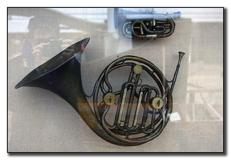

In [19]:
image = image_list[0]
image

## Split Validation

In [20]:
image = image_list.items[0]
print(image)
print(image.parent)
print(image.parent.parent)
print(image.parent.parent.name)

/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG
/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916
/Users/jacklu/.fastai/data/imagenette2-160/train
train


In [21]:
#export
def split_grandparent(filepath, train_name='train', valid_name='valid'):
    ret = {valid_name: False, train_name: True}
    return ret.get(filepath.parent.parent.name, None)

def split_by_fn(item_list, fn):
    mask = [fn(o) for o in item_list]
    true  = [o for o, m in zip(item_list, mask) if m == True]
    false = [o for o, m in zip(item_list, mask) if m == False]
    return true, false    

In [22]:
splitter = partial(split_grandparent, train_name='train', valid_name='val')

In [23]:
%time train, valid = split_by_fn(image_list, splitter)

CPU times: user 35.9 ms, sys: 716 µs, total: 36.6 ms
Wall time: 36 ms


In [24]:
print(f'train: {len(train)}')
print(train[:3])
print()
print(f'valid: {len(valid)}')
print(valid[:3])

train: 9469
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG')]

valid: 3925
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03394916/n03394916_69132.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/val/n03394916/n03394916_33771.JPEG')]


In [25]:
#export
class SplitData():
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid
    
    def __getattr__(self, k):
        # delegate getattr
        return getattr(self.train, k)
    
    def __setstate__(self, data: Any):
        # for pickling
        self.__dict__.update(data)
        
    @classmethod
    def split_by_fn(cls, item_list, fn):
        splitted = split_by_fn(item_list, fn)
        lists = map(lambda items: item_list.new(items), splitted)
        return cls(*lists)
    
    def __repr__(self):
        return f'{self.__class__.__name__}\n\nTRAIN:\n{self.train}\n\nVALID:\n{self.valid}\n'

In [26]:
splitted_data = SplitData.split_by_fn(image_list, splitter)
print(splitted_data)

SplitData

TRAIN:
Path: /Users/jacklu/.fastai/data/imagenette2-160
ImageList (9469 items)
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/t

## Labeling

In [27]:
#export
class Processor():
    def process(self, items):
        return items

class CategoryProcessor(Processor):
    def __init__(self):
        self.vocab = None
    
    # process/deprocess 1 item
    def proc(self, item):
        return self.o2i[item]
    def deproc(self, label):
        return self.vocab[label]
    
    def __call__(self, items):
        if not self.vocab:
            self.vocab = uniqueify(items)
            self.o2i = {v: k for k, v in enumerate(self.vocab)}
        return [self.proc(o) for o in items]
    
    def deprocess(self, idxs):
        assert self.vocab, 'uninitialized vocab in CategoryProcessor'
        return [self.deproc(i) for i in idxs]

In [28]:
#export
def p_name(filepath):
    return filepath.parent.name

def gp_name(filepath):
    return filepath.parent.parent.name

In [29]:
print(image)
print(image.name)
print(p_name(image))
print(gp_name(image))

/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG
ILSVRC2012_val_00046669.JPEG
n03394916
train


In [30]:
#export
class LabeledData():
    def __init__(self, x, y, proc_x, proc_y):
        self.x = self.process(x, proc_x)
        self.y = self.process(y, proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nx data: {self.x}\ny data: {self.y}\n'

    def process(self, item_list, proc):
        return item_list.new(compose(item_list.items, proc))
        
    def obj(self, items, i, procs):
        isint = isinstance(i, int) or isinstance(i, torch.LongTensor) and not i.ndim
        item = items[i]
        for proc in reversed(listify(procs)):
            item = proc.deproc(item) if isint else proc.deprocess(item)
        return item
        
    def x_obj(self, i):
        return self.obj(self.x, i, self.proc_x)
    
    def y_obj(self, i):
        return self.obj(self.y, i, self.proc_y)

    @classmethod
    def label_by_fn(cls, item_list, fn, proc_x=None, proc_y=None):
        labels = [fn(o) for o in item_list.items]
        labels = ItemList(labels, path=item_list.path)
        return cls(item_list, labels, proc_x, proc_y)
    
def label_by_fn(splitted_data, fn, proc_x=None, proc_y=None):
    train = LabeledData.label_by_fn(splitted_data.train, fn, proc_x, proc_y)
    valid = LabeledData.label_by_fn(splitted_data.valid, fn, proc_x, proc_y)
    return SplitData(train, valid)

In [31]:
label_list = label_by_fn(splitted_data, p_name, proc_y=CategoryProcessor())

In [32]:
assert label_list.train.proc_y == label_list.valid.proc_y

In [33]:
print(label_list.x)
print()
print(label_list.y)

Path: /Users/jacklu/.fastai/data/imagenette2-160
ImageList (9469 items)
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03

In [34]:
print(label_list.train.y.items[0])
print(label_list.train.y_obj(0))
print(label_list.train.y_obj(slice(1, 3)))

0
n03394916
['n03394916', 'n03394916']


In [35]:
label_list

SplitData

TRAIN:
LabeledData
x data: Path: /Users/jacklu/.fastai/data/imagenette2-160
ImageList (9469 items)
[PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/jacklu/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/jacklu/.fastai/da

## Transform to Tensor

In [36]:
transforms = [to_black_white, make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

image_list = ImageList.from_files(path, transforms=transforms)
splitted_data = SplitData.split_by_fn(image_list, splitter)
image_list = label_by_fn(splitted_data, p_name, proc_y=CategoryProcessor())

In [37]:
#export
def show_image(img, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

In [38]:
x, y = image_list.train[0]
x.shape

torch.Size([3, 128, 128])

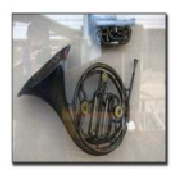

In [39]:
show_image(x)

## DataBunch

In [40]:
batch_size = 64

In [41]:
from torch.utils.data import DataLoader

def get_data_loaders(train_ds, valid_ds, batch_size, **kwargs):
    return (DataLoader(train_ds, batch_size=batch_size,   shuffle=True,  **kwargs),
            DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, **kwargs))

In [42]:
train_dl, valid_dl = get_data_loaders(image_list.train, image_list.valid, batch_size)

In [43]:
x,y = next(iter(train_dl))
print(x.shape)
print(y.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64])


label: 3


'n02102040'

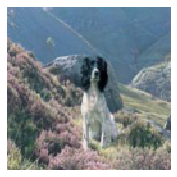

In [44]:
# rerun for random images
i = random.randint(0, len(x)-1)
print(f'label: {y[i].item()}')
show_image(x[i])
label_list.train.proc_y.vocab[y[i]]

In [45]:
# improved data bunch
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.c_in = c_in
        self.c_out = c_out
        
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    def valid_ds(self):
        return self.valid_dl.dataset
    
    def __repr__(self):
        return f'(DataBunch) \n\t{self.train_dl}\n\t{self.valid_dl}'

In [46]:
def databunchify(splitted_data, batch_size, c_in=None, c_out=None, **kwargs):
    data_loaders = get_data_loaders(splitted_data.train, splitted_data.valid, batch_size, **kwargs)
    return DataBunch(*data_loaders, c_in, c_out)

SplitData.to_databunch = databunchify

In [47]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
transforms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

item_list = ImageList.from_files(path, transforms=transforms)
sd = SplitData.split_by_fn(item_list, partial(split_grandparent, valid_name='val', train_name='train'))
label_list = label_by_fn(sd, p_name, proc_y=CategoryProcessor())
data_bunch = label_list.to_databunch(batch_size, c_in=3, c_out=10, num_workers=4)